Student: Matteo Salami

ID : 513974

#Implementation of a Graph Convolution Network (GCN) for binary node classification

reuired imports

In [1]:
import requests
import pickle as pk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras import metrics
from sklearn.utils.class_weight import compute_class_weight
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import l2

First we load the data via github repository

In [2]:
!wget -O input_data.pkl "https://github.com/M4tteoo/Dl_Project-/raw/main/input_data.pkl"

--2025-03-02 21:20:41--  https://github.com/M4tteoo/Dl_Project-/raw/main/input_data.pkl
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/M4tteoo/Dl_Project-/main/input_data.pkl [following]
--2025-03-02 21:20:41--  https://raw.githubusercontent.com/M4tteoo/Dl_Project-/main/input_data.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 563771 (551K) [application/octet-stream]
Saving to: ‘input_data.pkl’

input_data.pkl      100%[===================>] 550.56K  --.-KB/s    in 0.009s  

2025-03-02 21:20:41 (62.0 MB/s) - ‘input_data.pkl’ saved [563771/563771]



In [3]:
with open("input_data.pkl", "rb") as f:
    dd = pk.load(f)

triplets = dd["triplets"]
y = dd["y"]
y_true = dd["y_true"]

print(np.unique(y["label"]))
print(y.label.value_counts())

[-1  0  1]
label
-1    4517
 0     100
 1      27
Name: count, dtype: int64


# 2. INPUT

We check if the node ID's are sequential

In [4]:
#check if sequential
# Extract unique node IDs from y
node_ids = np.sort(y["Node"].unique())

# Check if the node IDs form a perfect sequence starting from 1
is_sequential = np.array_equal(node_ids, np.arange(1, len(node_ids) + 1))

print("Are node IDs in y sequential?", is_sequential)

Are node IDs in y sequential? True


Converting the labels from {-1, 1} to {0, 1} is necessary because of the chosen loss function i.e. Binary Cross Entropy (BCE)

In [5]:
#create a mask for unlabelled nodes (that are labelled with '0' in y)
unlabeled_mask = (y == 0)

# Convert {-1, 1} → {0, 1}
y = y.replace({-1: 0, 1: 1})
y_true = y_true.replace({-1: 0, 1: 1})

# tomake sure unlabelled nodes stay marked
y[unlabeled_mask] = -1

Also we need to make sure that node id's start from 0.

the following transofrmation method is used because the nodes are sequential, otherwise a more complex mapping method should have been included

In [6]:
#set node column to start from 0
y["Node"] -= 1
y_true["Node"] -= 1

#do the same for triplets
triplets["Node1"] -= 1
triplets["Node2"] -= 1

In [7]:
print("Min Node1 index:", triplets["Node1"].min())  # Should be 0
print("Max Node1 index:", triplets["Node1"].max())  # Should be <= num_Nodes - 1

print("Min Node2 index:", triplets["Node2"].min())  # Should be 0
print("Max Node2 index:", triplets["Node2"].max())  # Should be <= num_nodes - 1

Min Node1 index: 0
Max Node1 index: 4643
Min Node2 index: 0
Max Node2 index: 4643


##Some data visualisation:

the dataset consists of three pandas dataframes



In [8]:
for key, value in dd.items():
    print(f"{key}: type={type(value)}, length={len(value) if hasattr(value, '__len__') else 'N/A'}")

triplets: type=<class 'pandas.core.frame.DataFrame'>, length=17236
y: type=<class 'pandas.core.frame.DataFrame'>, length=4644
y_true: type=<class 'pandas.core.frame.DataFrame'>, length=4644


In [9]:
triplets.head()

,Node1,Node2,Weight
0,0,1315,0.1216
1,0,4604,0.1193
2,1,2,0.0371
3,1,1019,0.0407
4,1,3085,0.0414


In [10]:
y.head()

,Node,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [11]:
y_true.head()

,Node,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [12]:
np.unique(y_true["label"])

array([0, 1])

Check for null values

In [13]:
print(triplets.isnull().sum())
print(y.isnull().sum())
print(y_true.isnull().sum())

Node1     0
Node2     0
Weight    0
dtype: int64
Node     0
label    0
dtype: int64
Node     0
label    0
dtype: int64


#Creating the adjacency matrix A (2. INPUT)

The matrix is constructed using the data in the "Triplets" dataframe and is then converted to sparse matrix for efficiency purposes.

In [14]:
# Extract node pairs and weights from the triplets DataFrame
node1 = triplets.iloc[:, 0].values
node2 = triplets.iloc[:, 1].values
weights = triplets.iloc[:, 2].values

# Mapping from unique node IDs to contiguous indices
unique_nodes = np.unique(np.concatenate([node1, node2]))
node_to_index = {node: i for i, node in enumerate(unique_nodes)}

# Number of nodes
num_nodes = len(unique_nodes)

# Initialize an empty matrix
adj_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float32)

# Fill the matrix with weights
for n1, n2, w in zip(node1, node2, weights):
    i, j = node_to_index[n1], node_to_index[n2]
    adj_matrix[i, j] = w  # Directed graph (one-way connection)
    adj_matrix[j, i] = w  # Uncomment this line if the graph is undirected

# Convert adjacency matrix to a sparse matrix
adj_sparse = sp.csr_matrix(adj_matrix)

# matrix properties
print("Adjacency matrix shape:", adj_sparse.shape)
print("Number of nonzero elements:", adj_sparse.nnz)


Adjacency matrix shape: (4644, 4644)
Number of nonzero elements: 17236


###Applying symmetric normalisation to the A matrix (2. INPUT)

In [15]:
def normalize_adjacency(adj):
    """Perform symmetric normalization of adjacency matrix: D^(-1/2) A D^(-1/2)."""
    # Compute degree matrix D
    degree = np.array(adj.sum(axis=1)).flatten()  # Sum of each row (node degree)
    D_inv_sqrt = np.power(degree, -0.5)  # Compute D^(-1/2)
    D_inv_sqrt[np.isinf(D_inv_sqrt)] = 0  # Handle division by zero

    # Convert to sparse diagonal matrix
    D_inv_sqrt_mat = sp.diags(D_inv_sqrt)

    # Compute normalized adjacency matrix: D^(-1/2) A D^(-1/2)
    adj_normalized = D_inv_sqrt_mat @ adj @ D_inv_sqrt_mat

    return adj_normalized

# Apply normalization to the adjacency matrix
adj_normalized = normalize_adjacency(adj_sparse)

# Print properties
print("Normalized adjacency matrix shape:", adj_normalized.shape)
print("Number of nonzero elements:", adj_normalized.nnz)


Normalized adjacency matrix shape: (4644, 4644)
Number of nonzero elements: 17236


#**CHANGE**

In the exam this part of the process was not specified - creating an embedding matrix - but it is fundamental for the model to work to have node representations to update and then finally output.

##Creating embedding matrix

No explicit features for each node were given in the original dataset so it is necessary to initialise them. Necessary to create the node features array (was not clearly specified in my exam)

In this case I used 64-dim trainable embeddings

Row i (0 ≤ i ≤ 4643) stores the embedding for node i + 1 (original ID).


In [16]:
# Number of nodes and embedding dimension
num_nodes = adj_normalized.shape[0]
num_features = 64

# Trainable embeddings for each node (indexed from 0 to 4643)
node_embeddings = tf.Variable(
    tf.random.normal([num_nodes, num_features]), dtype=tf.float32, trainable=True
)

print("Trainable node embeddings shape:", node_embeddings.shape)

Trainable node embeddings shape: (4644, 64)


We extract the edges and weights from the normalized adjacency matrix (A) because the GCN layer needs the input to be in a specific format to perform message passing and aggregation.

adj_normalized.nonzero() extracts the row and column indices where the adjacency matrix has nonzero values, meaning there is an edge between these nodes.

adj_normalized.data retrieves the actual normalized edge weights.
This results in a list of edges and their respective weights, which can be subsequentlly fed into the GCN.

In [17]:
# Extract edges (i, j) and corresponding weights from the normalized adjacency matrix
edge_indices = np.vstack(adj_normalized.nonzero())
edges = tf.convert_to_tensor(edge_indices, dtype=tf.int32)

weights = tf.convert_to_tensor(adj_normalized.data, dtype=tf.float32)

print("edges shape:", edges.shape)
print("weights shape:", weights.shape)

edges shape: (2, 17236)
weights shape: (17236,)


###What we have so far


Edges & Weights
Extracted from the normalized adjacency matrix.
Represented as edge index (a list of node pairs) and edge weights.

Node Representations
Created using trainable embeddings.

# Now we can create a graph info tuple

which will be input to the gcn_model

In [18]:
graph_info = (node_embeddings, edges, weights)

In [19]:
print(type(graph_info[0]))  # Node features
print(type(graph_info[1]))  # Edges
print(type(graph_info[2]))  # Edge weights

<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


### definition of an MLP function for later use

Here I also included the L2 regularisation specified in the exam (5. MODEL)

Also the utilised activation function is the ReLU, also talked about in the same exam section (5. MODEL)

###CHANGE

In the exam, while writing the solution, i forgot to mention the use of dropout among the regularisation methods. I consider adding it to the model a correction of a mistake.

But in order to not go against the requirement of maximum adherence i commented out the lines were it was included. To let it be a part of the model it would be sufficient to uncomment those lines.

In [20]:
def MLP(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.Dense(units, kernel_regularizer=l2(0.0005)))
        #fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.relu))

    return keras.Sequential(fnn_layers, name=name)

    return keras.Sequential(fnn_layers, name=name)

##Below the code for a Graph convolutional layer

it follows three main steps:

1.   Message Preparation - compute messages from neighbouring nodes
2.   Message aggregation - aggregate the compute messages according to "aggregation_type"
3.   Node update - update node representations using aggregated messages





In [21]:
# code fo a convolutional layer
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        update_type="MLP",
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.update_type = update_type
        self.normalize = normalize

        self.prepare_fun = MLP(hidden_units, dropout_rate)

        if update_type == "MLP":
          self.update_fun = MLP(hidden_units, dropout_rate)
        # else .....

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.prepare_fun(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        # Linear: Add node_repesentations and aggregated_messages.
        h = node_repesentations + aggregated_messages


        # Apply the processing function (f_v).
        node_embeddings = self.update_fun(h)

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)  #l2 regularisation
        return node_embeddings

    def call(self, inputs):

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        # Gather slices from node_repesentations according to neighbour_indices
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

#5. MODEL

#**CHANGE**
The typical model structure in case of node classification tasks is: preprocessing FFN --> GCN Layer--> GCN Layer--> Postprocessing FFN

 In the exam I misteakenly did not specify the presence of a preprocessing FFN because I got fooled by the fact that no explicit node featrues (e.g. BoW vectors in the case of articles) were not given and so I thought an initial FFN would be superfluous. While actualy it can be of great benefit to the model (which would actually also work without it).

So finally in this section were included:

1.   Layer normalisation
2.   output layer with 1 unit and *sigmoid* activation (3. OUTPUT)
3.   GCN layers and the FFNs



In [22]:
num_classes = 2

# dimension of last hidden layer will be the node-embedding dimension
hidden_units = [128, 64]
dropout_rate = 0.2

In [23]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units, # to be used in function MLP
        aggregation_type="mean",
        update_type="MLP",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

       # unpack graph_info
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])

        #Layer normalisation
        self.layer_norm = layers.LayerNormalization()

        # a pre-process layer.
        self.preprocess = MLP(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            update_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            update_type,
            normalize,
            name="graph_conv2",
        )
        # Create a post-process layer.
        self.postprocess = MLP(hidden_units, dropout_rate, name="postprocess")
        # Create a compute output layer.
        self.compute_out = layers.Dense(units= 1,
                                        activation="sigmoid",
                                        kernel_regularizer=l2(0.0005),  # L2 Regularization
                                        name="out")

    def call(self, input_node_indices):
        # input_node_indices represent our ```batch```
        # Preprocess the node_features to produce node representations.
        #  that is, nodes features are pre-embedded before graph convolution
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x1 = self.layer_norm(x1)
          # Skip connection. (This helps with gradient flow in deep networks.)
          #x = x1 + x
        # no skip connection
        x=x1
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        x2 = self.layer_norm(x2)

           # Skip connection.
           #x = x2 + x
        # no skip connection
        x = x2
        # Postprocess node embedding.
        x = self.postprocess(x)
        x = self.layer_norm(x)

        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        out = self.compute_out(node_embeddings)
        return out

Instantiation of the model

In [24]:
gcn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)
# invoking a prediction for nodes of indices 1, 10, 100
node_indices = tf.convert_to_tensor([1, 10, 100], dtype=tf.int32)
print("GNN output shape:", gcn_model(node_indices))


history=gcn_model.summary()

GNN output shape: tf.Tensor(
[[0.55341595]
 [0.6427591 ]
 [0.620585  ]], shape=(3, 1), dtype=float32)


Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer_normalization                  │ (4644, 64)                  │             128 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocess (Sequential)              │ (4644, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv1 (GraphConvLayer)         │ ?                           │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ graph_conv2 (GraphConvLayer)         │ ?                           │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ postprocess (Sequential)             │ (4644, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out (Dense)                          │ (3, 1)                      │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 223,681 (873.75 KB)

 Trainable params: 223,681 (873.75 KB)

 Non-trainable params: 0 (0.00 B)

#6. MODEL EVALUATION

##Graph-Aware train test splitting

1 Convert triplets into a graph representation

2	Perform random walk sampling to select train nodes

3	Ensure the train and test graph remains connected

4 Split labels and edges accordingly

In [25]:
import networkx as nx
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from sklearn.model_selection import StratifiedShuffleSplit

# Step 1: Build Graph from triplets
G = nx.Graph()
edges = list(zip(triplets["Node1"], triplets["Node2"], triplets["Weight"]))
G.add_weighted_edges_from(edges)

# Step 2: Extract the largest connected component (LCC)
largest_cc = max(nx.connected_components(G), key=len)
G = G.subgraph(largest_cc).copy()
print(f"Largest Connected Component Size: {len(G.nodes)} nodes, {len(G.edges)} edges")

# Step 3: Get labels for nodes from 'y'
node_labels = dict(zip(y["Node"], y["label"]))

# Step 4: Perform Random Walk Sampling for training nodes
def random_walk_sampling(G, start_node, sample_size):
    sampled_nodes = {start_node}
    current_node = start_node

    while len(sampled_nodes) < sample_size:
        neighbors = list(G.neighbors(current_node))
        if not neighbors:  # Handle dead-end case
            current_node = random.choice(list(G.nodes))
        else:
            current_node = random.choice(neighbors)
            sampled_nodes.add(current_node)

    return sampled_nodes

# Select random start node & sample train nodes
sample_size = int(0.8 * len(G.nodes))  # 80% for training
start_node = random.choice(list(G.nodes))
train_nodes = random_walk_sampling(G, start_node, sample_size)

# Ensure the training graph remains connected
G_train = G.subgraph(train_nodes).copy()
while not nx.is_connected(G_train):
    train_nodes = random_walk_sampling(G, start_node, sample_size)
    G_train = G.subgraph(train_nodes).copy()

test_nodes = set(G.nodes) - train_nodes  # Remaining nodes for test set
G_test = G.subgraph(test_nodes).copy()

# Step 5: Prepare train-test labels
train_labels = np.array([node_labels[n] for n in train_nodes])
test_labels = np.array([node_labels[n] for n in test_nodes])

# Step 6: Apply Stratified Sampling to Maintain Class Balance
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_nodes = np.array(list(train_nodes))
test_nodes = np.array(list(test_nodes))

for train_idx, test_idx in splitter.split(train_nodes, train_labels):
    x_train, y_train = train_nodes[train_idx], train_labels[train_idx]
    x_test, y_test = train_nodes[test_idx], train_labels[test_idx]

# Step 7: Ensure Integer Indices for TensorFlow
x_train, x_test = x_train.astype(np.int32), x_test.astype(np.int32)

# Print Stats
print(f"Final Train nodes: {len(x_train)}, Test nodes: {len(x_test)}")
print(f"Final Train edges: {len(G_train.edges)}, Test edges: {len(G_test.edges)}")
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


Largest Connected Component Size: 4350 nodes, 8423 edges
Final Train nodes: 2784, Test nodes: 696
Final Train edges: 7159, Test edges: 503
x_train shape: (2784,), y_train shape: (2784,)
x_test shape: (696,), y_test shape: (696,)


In [26]:
print("Unique values in y_train:", np.unique(y_train))

Unique values in y_train: [-1  0  1]


###During training the unlabelled nodes (now labelled with -1) should not be present

they will be part of the testing section later

In [27]:
mask = y_train != -1  # True for labeled nodes (0 or 1), False for unlabeled (-1)

#Apply the mask to filter x_train and y_train
x_train = x_train[mask]
y_train = y_train[mask]

In [28]:
print(np.bincount(y_train))  # Check the counts of each class in y_train

[2698   21]


#training the GCN model


Manually defined f-1 score metric (6. MODEL EVALUATION)

Below also the other specified metrics, precision, recall and AUC, were included (6. MODEL EVALUATION)

In [29]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()


## 4. LOSS

Binary Cross Entropy was used as the loss function since the task is binary classification

In [30]:
learning_rate = 0.0005

gcn_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
          tf.keras.metrics.AUC(name="AUC"),
          tf.keras.metrics.Precision(name="precision"),
          tf.keras.metrics.Recall(name="recall"),
          F1Score(name="f1_score"),
        ]
)
# early stopping callback.
early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss",
    mode="min",
    patience=25,
    restore_best_weights=True
)

printing some initial predictions to check if the model works

In [31]:
print("Initial Model Predictions:", gcn_model.predict(x_train[:10]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
Initial Model Predictions: [[0.6346407 ]
 [0.47503057]
 [0.4658515 ]
 [0.6084817 ]
 [0.268768  ]
 [0.22570017]
 [0.7068896 ]
 [0.5418188 ]
 [0.37018636]
 [0.60095525]]


###CHANGE

Not considering, in my exam, any specific mehod to handle the severely unbalanced dataset, was clearly a mistake. Ohter methods (not considered here) are talked about in the final considerations

There are several methods that could provide helps towards managing this issue.

I decided to provide an implementation for a class weight to try and help the model in the learning process.

But I also decided **not** to make use of it to not go against exam policy (to make it part of the model it would be enough to uncomment the line "#class_weight=class_weights," in the fit() method)



In [32]:
# Compute class weights only for the labeled data
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = {c: w for c, w in zip(np.unique(y_train), class_weights)}

print("Class Weights:", class_weights)

Class Weights: {0: 0.5038917716827279, 1: 64.73809523809524}


I put a very **low** number of epochs to ensure that the code runs in a few **minutes**

Also I implemented a **stratified** split for the validation sets (6. MODEL EVALUATION)

In [33]:
num_epochs = 50
batch_size = 128

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, stratify=y_train, random_state=42
)
# Fit the model.
history = gcn_model.fit(
    x=x_train,
    y=y_train,
    #class_weight=class_weights,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping],
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 401ms/step - AUC: 0.5273 - f1_score: 0.0185 - loss: 0.7285 - precision: 0.0102 - recall: 0.1834 - val_AUC: 0.5056 - val_f1_score: 0.0000e+00 - val_loss: 0.5444 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - AUC: 0.5094 - f1_score: 0.0000e+00 - loss: 0.5436 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.4815 - val_f1_score: 0.0000e+00 - val_loss: 0.5261 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - AUC: 0.5450 - f1_score: 0.0000e+00 - loss: 0.5175 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.4778 - val_f1_score: 0.0000e+00 - val_loss: 0.5067 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 420ms/step - AUC: 0.7386 - f1_score: 0.0000e+00 - loss: 0.5009 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_AUC: 0.5333 - val_f1_score: 0.0000e+00 - val_loss: 0.4873 

###Learning Curves

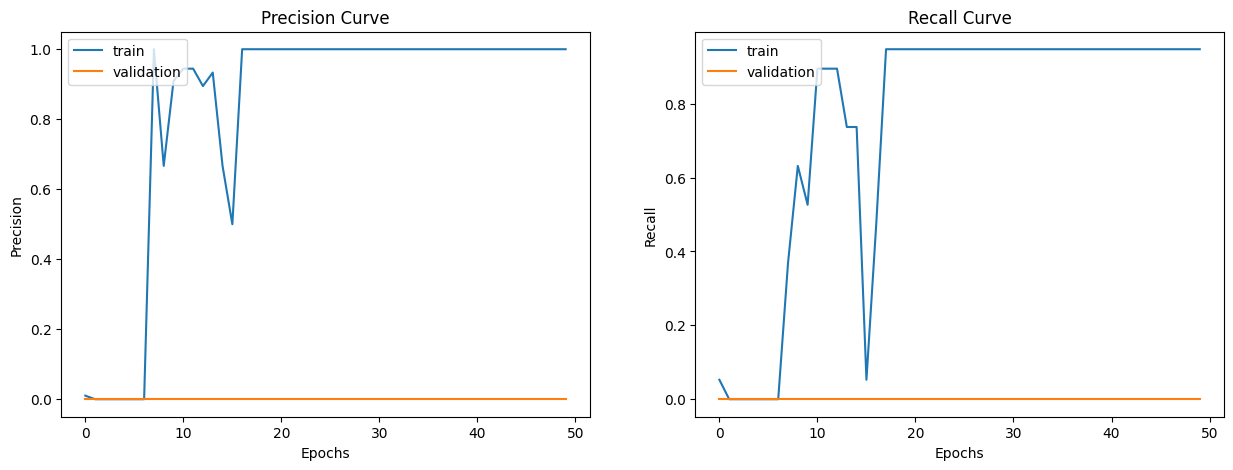

In [34]:
# Precision-Recall Curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history["precision"], label="train")
axes[0].plot(history.history["val_precision"], label="validation")
axes[0].legend(loc="upper left")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Precision")
axes[0].set_title("Precision Curve")

axes[1].plot(history.history["recall"], label="train")
axes[1].plot(history.history["val_recall"], label="validation")
axes[1].legend(loc="upper left")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Recall")
axes[1].set_title("Recall Curve")

plt.show()

##Next: test the model on the test set and on the masked nodes

In [35]:
test_results = gcn_model.evaluate(x_test, y_test, batch_size=batch_size)
print("Test Results:", dict(zip(gcn_model.metrics_names, test_results)))


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - AUC: 0.4976 - f1_score: 0.0000e+00 - loss: 0.0148 - precision: 0.0000e+00 - recall: 0.0000e+00
Test Results: {'loss': 0.02011675201356411, 'compile_metrics': 0.49629080295562744}


In [36]:
# Get model predictions
y_pred = gcn_model.predict(x_test)

# Check min and max values
print("Min:", np.min(y_pred))
print("Max:", np.max(y_pred))

# Check a few sample predictions
print("Sample predictions:", y_pred[:10])

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step
Min: 0.0003906305
Max: 0.8373004
Sample predictions: [[0.00047135]
 [0.00047383]
 [0.00043799]
 [0.0004353 ]
 [0.00043031]
 [0.0004379 ]
 [0.00044341]
 [0.00045983]
 [0.00046354]
 [0.00043865]]


Classify unlabelled nodes

In [37]:
#Identify unlabeled nodes
unlabeled_mask = y["label"] == -1  # Boolean mask for unlabeled nodes
unlabeled_nodes = y["Node"][unlabeled_mask].to_numpy().astype(np.int32)  # Extract node indices

unlabeled_nodes_tensor = tf.convert_to_tensor(unlabeled_nodes, dtype=tf.int32)

#Use the trained model to predict on these nodes
unlabeled_predictions = gcn_model.predict(unlabeled_nodes)

# Step 3: Get the true labels (y_true) for these previously unlabeled nodes
y_true_unlabeled = y_true[y_true["Node"].isin(unlabeled_nodes)]["label"].to_numpy()

print("labels from y_true", y_true_unlabeled)

# Convert predictions to binary (assuming a threshold of 0.5 for classification)
binary_preds = (unlabeled_predictions.flatten() >= 0.5).astype(int)
print("predicted labels", binary_preds)



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
labels from y_true [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
predicted labels [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


#FINAL CONSIEDERATIONS

From the learnign curves and the performance metrics (both on validation and test sets) it is cleary derivable the conclusion that the model failed to learn meaningful patterns for the underepresented class.

The possible improvements are various but since they were not included in the exam they were not included in the final project.



1.   Use Focal loss function instead of BCE to better handle class imbalance
1.   Perform hyperparameter tuning using a Grid search (learning rate, number of units, number of layers etcetera )
2.   Augment the minority class by for example using an Oversampling technique to add synthetic edges
3. Utilising LeakyReLU instead of simple ReLU
4. Create a simpler model to compare performances
5. It was also possible to fine-tune the StratifiedShuffleSplit (Graph-Aware split section) parameters to adjust the train-test ratio accordingly, in order to better handle class imbalance.


